<a href="https://colab.research.google.com/github/sidijju/FastMRI/blob/master/ProcessData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Process Data

This notebook document my progress in recovering and manipulating k-space data from a sample image from the OASIS3 dataset. 

Data were provided [in part] by OASIS-3: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P50AG00561, P30NS09857781, P01AG026276, P01AG003991, R01AG043434, UL1TR000448, R01EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.

##Import Required Libraries

In [66]:
!pip install dicom
!pip install tensorflow

import tensorflow as tf
import numpy as np
import dicom
import os
import numpy
from matplotlib import pyplot as plt, cm


##Import Data from Github (data provided by OASIS3)

In [54]:
!git clone https://github.com/sidijju/Other
os.chdir("Other")
!ls
!pwd

Cloning into 'Other'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.
 BRAINIX_DICOM_FLAIR_IM-0001-0001.dcm
 BRAINIX_DICOM_FLAIR_IM-0001-0011.dcm
'Despacito 2 (Parody Video) (320  kbps).mp3'
'Despacito 2 (Parody Video) (320 kbps) (online-audio-converter.com).wav'
 README.md
/content/Other/Other


In [55]:
filesDCM = []
for dirName, subdirList, fileList in os.walk("/content/Other"):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            filesDCM.append(os.path.join(dirName,filename))
print(filesDCM)

['/content/Other/BRAINIX_DICOM_FLAIR_IM-0001-0001.dcm', '/content/Other/BRAINIX_DICOM_FLAIR_IM-0001-0011.dcm', '/content/Other/Other/BRAINIX_DICOM_FLAIR_IM-0001-0001.dcm', '/content/Other/Other/BRAINIX_DICOM_FLAIR_IM-0001-0011.dcm']


##Process and Display Images

In [56]:
# Get ref file
RefDs = dicom.read_file(filesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(filesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

print(ConstPixelDims)
print(ConstPixelSpacing)

(288, 288, 4)
(0.79861110448837, 0.79861110448837, 5.0)


In [0]:
#calculate axes
x = numpy.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = numpy.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = numpy.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

In [0]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = numpy.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in filesDCM:
    # read the file
    ds = dicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, filesDCM.index(filenameDCM)] = ds.pixel_array  

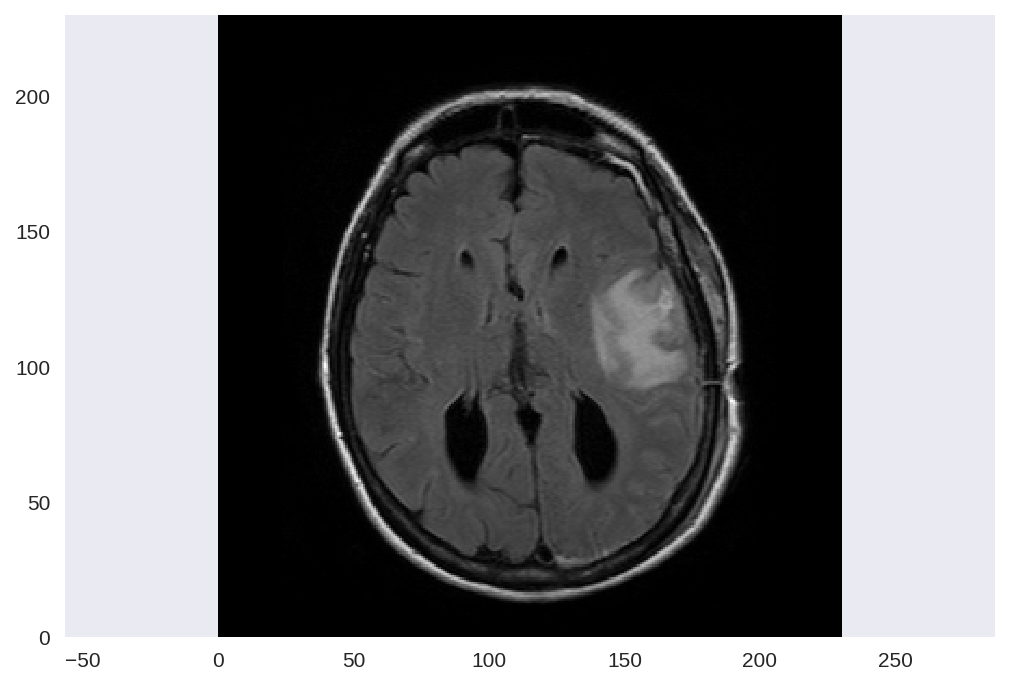

In [59]:
pyplot.figure(dpi=150)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
im = numpy.flipud(ArrayDicom[:, :, 1])
pyplot.pcolormesh(x, y, im)


##Recover and Compare k-space 

In [0]:
from scipy import fftpack

# Show the results

def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

In [61]:
#half sample original k-space image
im_halfsampling = numpy.zeros((288, 288))
for i in range(144):
  im_halfsampling[2*i] = im_fft[2*i]
  im_halfsampling[2*i+1] = np.ones((1, 288))
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


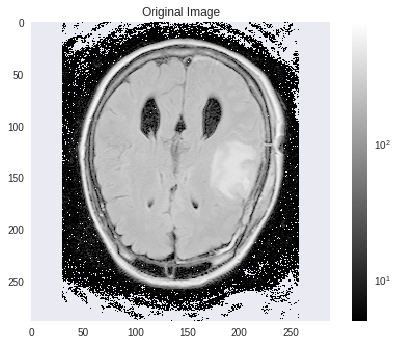

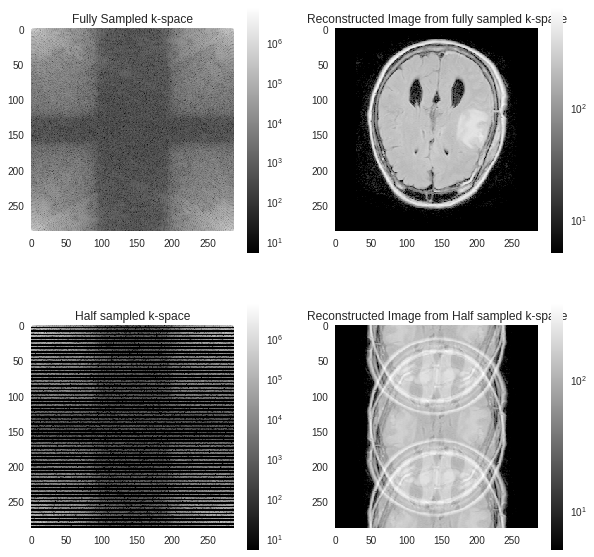

In [79]:
plt.figure()
plt.grid(False)
plot_spectrum(im)
plt.title('Original Image')

fig = plt.figure(figsize = (10, 10))

fig.add_subplot(221)
im_fft = fftpack.fft2(im)
plt.grid(False)
plot_spectrum(im_fft)
plt.title('Fully Sampled k-space')


im_reconstruct = fftpack.ifft2(im_fft)
fig.add_subplot(222)
plt.grid(False)
plot_spectrum(im_reconstruct)
plt.title('Reconstructed Image from fully sampled k-space')

fig.add_subplot(223)
plt.grid(False)
plot_spectrum(im_halfsampling)
plt.title('Half sampled k-space')

im_reconhalf = fftpack.ifft2(im_halfsampling)
fig.add_subplot(224)
plt.grid(False)
plot_spectrum(im_reconhalf)
plt.title('Reconstructed Image from Half sampled k-space')

plt.show()